# 4. Evaluation Metrics For Classfication
In the Previous session we trained a model for churn. How do we know if it's any good?

## 4.1 Evaluation Metrics: Session Overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

Metric: Function that compares the prediction with the actual values and outputs a single numbers that tells that how good the prediction are.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [6]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [7]:
df = pd.read_csv(data)

df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:


df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes== 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype('int')
    

In [10]:
df_full_train, df_test = train_test_split(df, test_size = 0.2,random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25,random_state=1) 

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_test['churn']
del df_val['churn']

In [13]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [15]:
dv = DictVectorizer(sparse=False)

In [16]:
train_dict = df_train[numerical+categorical].to_dict('records')

X_train =dv.fit_transform(train_dict)

model = LogisticRegression()

model.fit(X_train, y_train)

C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [17]:
val_dict = df_val[numerical+categorical].to_dict('records')

X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

churn_prediction = (y_pred>=0.5)

(y_val == churn_prediction).mean()

np.float64(0.8026969481902059)

## 4.2 Accuracy and dummy model
- Evaluate the model on different thresholds
- Check the accuracy of the dummy baselines

### What is accuracy?

Accuracy is basically  the the number of correct predictions/number of total predictions.

e.g. 4 people are predicted not to churn, while 2 people are predicted to churn.

However, in reality, 2 people that are predicted not to churn did churn, while 1 person that is predicted to churn did not churn. That would mean that out of 6, only 3 predictions were correct.

Therefore, the accuracy of the model is 50%.

In [18]:
# Total Predictions
len(y_val)

1409

In [19]:
# Accuracy of churnnig

(churn_prediction == y_val).mean()

np.float64(0.8026969481902059)

In [21]:
# scikit-learn has module for this
from sklearn.metrics import accuracy_score

In [24]:
accuracy_score(y_val, y_pred>=0.5)

0.8026969481902059

### What are thresholds?
Recall that in our model, we made it such that if y_pred >= 0.5, it would be counted as 1. However, that probability can be adjusted such that we can make stricter predictions or more lenient predictions.

For example, instead of 0.5, we can make it such that anything from 0.3 onwards would be counted as 1, or anything from 0.74 would be counted as 1.

In [27]:
# Reacall linspace produces a np array with equal spacings
threshold = np.linspace(0, 1, 21)

scores = []

# Printing Threshold , printing accuracy acore  with the  threshold
for t in threshold:
    score = accuracy_score(y_val, y_pred>= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


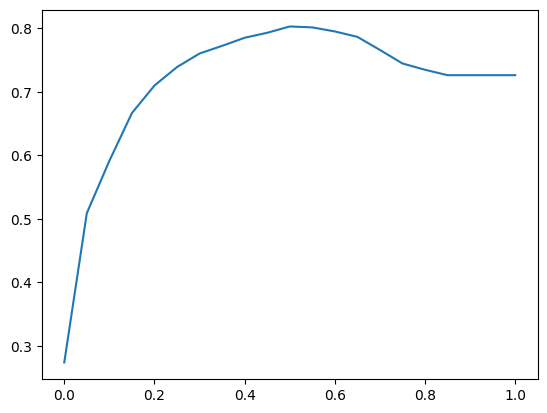

In [28]:
plt.plot(threshold, scores)

In [31]:
from collections import Counter



#### Afterthoughts of accuracy:

Accuracy does not tell us how good a model is if there is a class imbalance. Only with balanced data (such as data that is 50/50, or a bit more varied than that) would accuracy be a good metric to use. We have to look at other evaluation metrics


In [33]:
# counting stuff
Counter(y_pred>=1)

Counter({np.False_: 1409})

In [34]:
# There is a class imbalance - there are significantly more number of people that are not expected to churn.
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [35]:
# Percentage of people that ar not expecting to churn are

1 - y_val.mean()

np.float64(0.7260468417317246)

## Confusion Table

- Different Types of erros and correct decision
- Arranging them in a table


Basics of Confusion table/matrix(As some people would call it):
There are 2 possible scenarions when there is a prediction of no churn:
1. The customer indeed did'nt churn - also known as true negative
2. The cusotmer actually churned - also known as false negative

The same thing will happen when there is predictions of churn:
1. The customer indeed churned - also known as true positive
2. The customer actually did'nt churned - also known as false positive

These Four scenarios form the confusion-table/matrix

In [43]:
# Actual positives and negatives 
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [44]:
# Predictions with threshold 
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [45]:
# Four components of the confusion matrix

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [46]:
confusion_matrix = np.array([[tn, fp], [fn, tp]])
confusion_matrix

array([[921, 102],
       [176, 210]])

In [47]:
# Percentage rounded off to 2 dp

(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

Accuracy can be based on here, by looking at the probability of the true negatives and positives. 
This totals up to 0.8, which is the accuracy of our previous model.

## Precison and Recall

Some definitions here:

Precision: Fraction of positive predictions that are correct

Recall: Fraction of correctly identified positive predictions

In [48]:
# Precision

p = tp / (tp+fp)
p

np.float64(0.6730769230769231)

In [49]:
r = tp / (fn+tp)
r

np.float64(0.5440414507772021)

### Precision vs Recall when do we use it?

Answer: It depends on the situation at hand.

Sometimes, we would need to focus on precision a bit more than that of recall, and sometimes vice versa.

For example, we would need to focus more on recall if

## ROC Curves

#### TPR and FPR

In [50]:
# True Positive Rate aka true positives divided by total number of positives
# total number of positives = predicted positive, is positive (TP) + predicted negative, is positive (FN)
tpr = tp / (tp + fn)
tpr

np.float64(0.5440414507772021)

In [51]:
# False Positive Rate aka false positives divided total number of negatives
# total number of negatives = predicted negative, is negative (TN) + predicted positives, is negative (FP)
fpr = fp / (fp + tn)
fpr

np.float64(0.09970674486803519)

In [52]:
scores = []

# Creating an array of evenly-spaced probabilities from 0 to 1 (aka 0, 0.1, 0.2, ..., 0.99, 1)
thresholds = np.linspace(0, 1, 101)

# Printing true positives & negatives, false positives & negatives for each rate 
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    # List of tuples is created per threshold
    scores.append((t, tp, fp, fn, tn))

In [53]:
# Creating a dataframe for these scores so that we are able model the TPRs and FPRs for each threshold
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

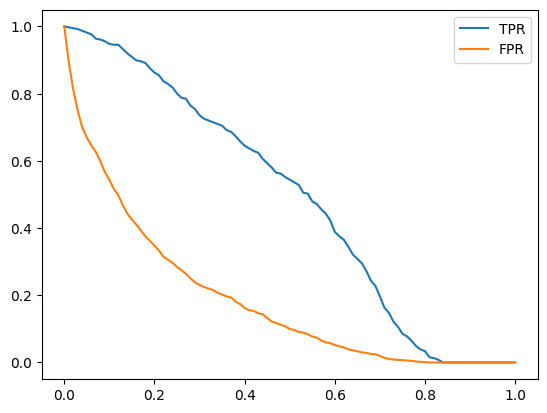

In [54]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

1. At threshold 0, we do predict everyone that churns as positive, so the TPR = 1. But at the same time, we do not predict anyone as negative. Therefore, the true negative = 0, and FPR = 1 since FP / FP + TN is effectively FP/FP which equals 1.
2. Both TPR and FPR goes down when we increase the threshold, but the FPR decreases at a faster rate. We do want the FPR to decrease faster!

Random model

We will be using this model as a baseline.


In [55]:
# Plucking numbers from a straight line distribution, size should be the same as validation data 
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [56]:
# Default threshold of 0.5 
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [57]:
# Using the previous function to create 
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [58]:
# We use y_random ffor the prediction values in this case
df_rand = tpr_fpr_dataframe(y_val, y_rand)

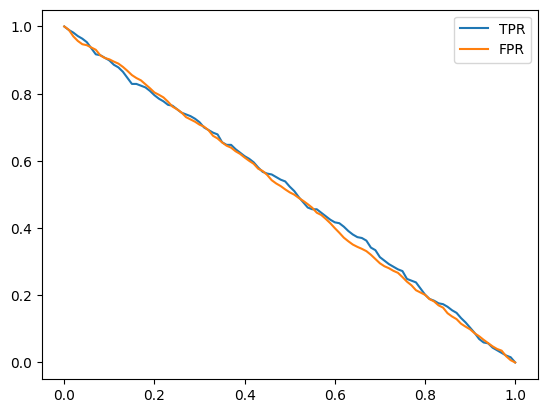

In [59]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

Ideal Model

In [60]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [61]:
# Repeating the 0 and 1 values according to the num_neg and num_pos 
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

# We create a ideal prediction dataset with values corresponding to 0 or 1 with regards to the threshold
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [62]:
# Rate of non-churning, aka the threshold which we will set this model with 
1 - y_val.mean()

np.float64(0.7260468417317246)

In [63]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [64]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


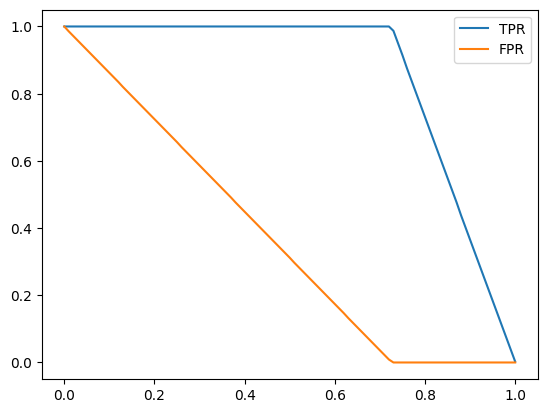

In [65]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()



True positive always remains at 1 until the threshold of 0.726 whereby it starts to drop.

The model still makes mistakes at anything before its threshold, since the FPR is still going down despite the TPR still remaining 1.


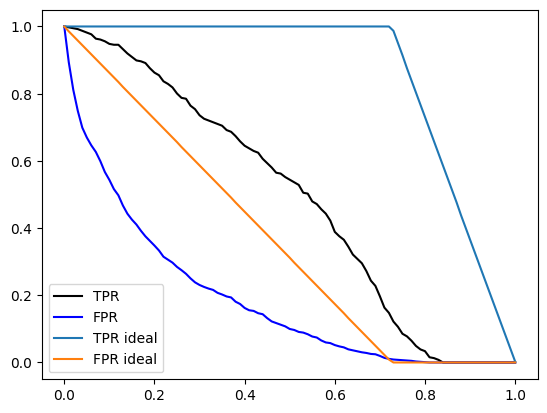

In [66]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()



We can see that both our TPR and FPR are rather far from the ideal rates themselves. Plotting against the threshold isn't always very intuitive, but what we can do is to plot FPR against TPR, also known as a ROC curve.


Text(0, 0.5, 'TPR')

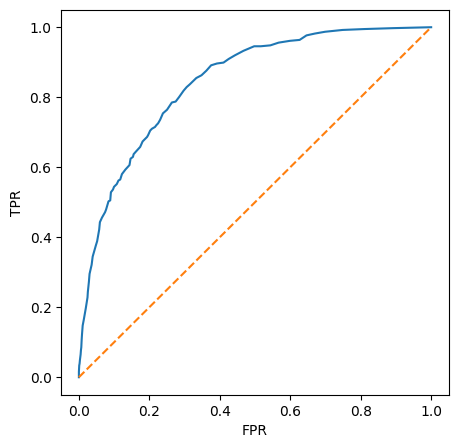

In [67]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')

#Uncomment if you want to see the random plot
#plt.plot(df_rand.fpr, df_rand.tpr, label = 'random')

# The random plot, simplified as ultiamtely it's still quite linear despite some fluctuations
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

# Uncomment this if you want to see the ideal plot
# We ultimately want our model plot to be as close to the ideal plot as possible
#plt.plot(df_ideal.fpr, df_ideal.tpr, label = 'ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')


For a guideline:

- The closer a model is to the ideal model, the better it is
- If it's closer to the random model but still above the model, it is not very good.
- Your model should NOT go below the random model itself, that means that there is something wrong.

In [68]:
from sklearn.metrics import roc_curve

In [69]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

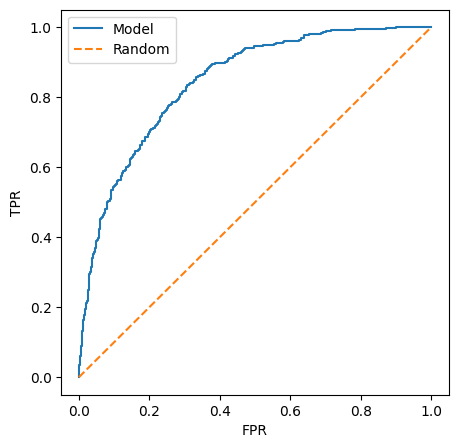

In [70]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC

- Area under the curve - useful metric
- Interpretation if AUC

The area under the curve is a very useful for the metric itself. To calculate the AUC, we will usually have to use calculus for this - but sklearn has a AUC function that doesn't need us to calculate the AUC.

We should, however, consider what the value of the AUC should be:

- It should definitely be more than 0.5 - the random model* that we did has a area of 0.5. If it is less than 0.5, there is definitely a problem with the curve itself.
- It should be as close to 1 as possible. The AUC of the ideal model is 1, and while we can't always achieve the ideal model, we should bring it as close to the ideal model as possible.

= Reason why the random model has an area of 0.5 is because we consider it as a straight line. This means that we can calculate the area under the line itself as a 'triangle'. At FPR = 1, TPR also = 1, therefore the 'triangle' random model has a length of 1 and height of 1. Area of triangle = 0.5 length * height, therefore AUC = 0.5.

In [72]:
# Area Under Curve function
# Do note that we can use any curve for this, not just the ROC curve 
from sklearn.metrics import auc

In [74]:
# AUC with our manually calculated values
auc(fpr, tpr)

0.8438555705812935

In [75]:
# Via sklearn, this is slightly more accurate.
auc(df_scores.fpr, df_scores.tpr)

0.8438454408703447

In [76]:
# AUC under ideal ROC curve
# The AUC is not 1 since we manually calculated it ourselves.
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [78]:
# Explanation for the roc_auc_score function itself! 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438555705812935

In [79]:
from sklearn.metrics import roc_auc_score

In [80]:
roc_auc_score(y_val, y_pred)

0.8438555705812935

In [81]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [82]:
import random

Ok, but what does AUC actually tell us?

AUC tells us the probability that a randomly selected positive example has a higher score than a randomly selected negative exmaple.

In [83]:
n = 100000
success = 0 

# random.randint returns random integer in range, including both the end points 
for i in range(n):
    # Calling the index of a random positive decision & random negative decision
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)
    
    # If randomly selected positive example has a higher score than a randomly selected negative example, +1
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

# Number of successes / total number of times. We can tell that it's rather close to our AUC metric
success / n

0.84571

In [84]:
# Using numpy instead
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

# Do note that the size of n will influence how close the AUC score is to the actual AUC score.

np.float64(0.84654)

## 4.7 Cross Validation
- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions




We use the full train dataset for cross-validation, leaving away the test dataset.

We split it into k parts and use different parts such that we're able to use different parts for training and validate in on another part. This is known as a fold.

After that, we record the metric used for the model itself. Once we have finished all our folds, we will be able to calculate things like the average metric and the standard deviation of the metrics.

For example: k = 3,

- We use parts 1 and 2 for training, and validating for part 3, recording the metric.
- We then use parts 1 and 3 for training, and validating for part 2, recording the metric.
- Finally we use parts 2 and 3 for training, and validating for part 1, recording the metric.



In [86]:
# Preprocessing + training of model
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [87]:
dv, model = train(df_train, y_train, C=0.001)

In [88]:
# Prediction of y values
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [89]:
y_pred = predict(df_val, dv, model)

In [90]:
from sklearn.model_selection import KFold

In [91]:
!pip install tqdm

In [93]:
# tqdm allows you to see the process for each iteration 
from tqdm.auto import tqdm

In [94]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        # the k-fold split uses index to shuffle the data
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        # y values come from dataset
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        # training and predicting
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        # AUC
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009


C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please als

C=0.01 0.840 +- 0.008


C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please als

C=0.1 0.842 +- 0.007


C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please als

C=0.5 0.842 +- 0.007


C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please als

C=1 0.842 +- 0.007


C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please als

C=5 0.842 +- 0.007


C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please als

C=10 0.842 +- 0.007


C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
scores

[0.8445533828920412,
 0.8449687955237716,
 0.8333172787477423,
 0.8348768146063823,
 0.8516127514040978]

In [96]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

C:\Users\AJAY\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8583138331870823

## 4.8 Summary
- Metric : a single number that describes the performance of a model
- Accuracy : fraction of correct answers; sometimes misleading
- Precision and recall are less misleading when we have class inbalance
- ROC Curve : a way to evaluate the performance at all thresholds; okay to use with imbalance
- K-Fold CV : more reliable estimate for performance (mean + std)

## 4.9 Explore More
-Check the precision and recall of the dummy classifier that always predict "FALSE"
- F1 score = 2 P R / (P + R)
- Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
- Area under the PR curve is also a useful metric

Other projects:

- Calculate the metrics for datasets from the previous week